## Initialization

### Imports and Globals

In [1]:
using Pkg
Pkg.activate("../one_flav_env")

using LHEF
using LorentzVectorHEP
using LinearAlgebra
using LaTeXStrings
using DelimitedFiles: readdlm
using PythonPlot

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")

MG_RESULTS_DIR = "../madgraph/"
FIGDIR = "./"

# make sure these match what the script has output
DIR_llνν = MG_RESULTS_DIR * "mumu_to_llvv/"
DIR_φφ = MG_RESULTS_DIR * "mumu_to_phiphi/"
DIR_llχχ = MG_RESULTS_DIR * "mumu_to_llchichi/"

# below is stuff that shouldn't change (because it's default in madgraph)
# but if we decide to do more masses we might have to mess around with it
DIR_run01 = "Events/run_01/"
DIR_run02 = "Events/run_02/" # the second run is only applicable to the mφ scan
XSEC_RESULTS_FILENAME = "xsec.txt" # for the SM run
SCAN_RESULTS_FILENAME = "Events/scan_run_0[1-2].txt" # only applicable to LFDM
LHE_FILENAME = "unweighted_events.lhe.gz"
;

  Activating project at `~/Dropbox (University of Oregon)/MuC/Aria/one_flav/code/one_flav_env`


### Standard Functions

In [2]:
function load_mg_xsec(file::String)
    Vector{Float64}(readdlm(file, skipstart=1)[:,3])
end

function load_mg_masses(file::String)
    Vector{Float64}(readdlm(file, skipstart=1)[:,2])
end

lhe_v4(p) = LorentzVector(p.e, p.px, p.py, p.pz)
lhe_v3(p) = [p.px, p.py, p.pz]

function find_leptons(event)
    idxs = Vector{Int64}()
    for p in event.particles[3:end]
        if p.id in [11,-11,13,-13]
            append!(idxs, p.idx)
        end
    end
    return idxs
end

function check_leptons(events)
    for (i,e) in enumerate(events)
        if length(find_leptons(e)) > 2
            throw(ArgumentError("Too many leptons in event $i"))
        end
    end
end

function dilepton_summarize(event::LHEF.Event)
    l_idx = find_leptons(event)

    p1 = lhe_v4(event.particles[l_idx[1]])
    p2 = lhe_v4(event.particles[l_idx[2]])

    p1_3 = lhe_v3(event.particles[l_idx[1]])
    p2_3 = lhe_v3(event.particles[l_idx[2]])

    inv_mass = mass(p1+p2)
    pT = pt(p1+p2)
    open_angle = (p1_3 ⋅ p2_3) / (norm(p1_3)*norm(p2_3))
    deltaR = ΔR(p1, p2)

    return [inv_mass, pT, open_angle, deltaR]
end

dilepton_summarize(lhe::Vector{LHEF.Event}) = reduce(hcat, dilepton_summarize.(lhe))

function dilepton_pT(event)
    l_idx = find_leptons(event)

    p1 = lhe_v4(event.particles[l_idx[1]])
    p2 = lhe_v4(event.particles[l_idx[2]])

    return pt(p1+p2)
end
;

## Histograms

### Histogram Function

In [3]:
function make_histograms(lhe1, lhe2, lhe_bkg, labels, title; nbins=50)

    check_leptons(lhe1)
    check_leptons(lhe2)
    check_leptons(lhe_bkg)

    sig1_summary = reduce(hcat, dilepton_summarize.(lhe1))
    sig2_summary = reduce(hcat, dilepton_summarize.(lhe2))
    bkg_summary = reduce(hcat, dilepton_summarize.(lhe_bkg))

    yscales = ["log", "log", "linear", "linear"]
    xlabels = [L"$m_{ll}$ [GeV]", L"$p_{T,ll}$ [GeV]", L"\cos(\theta_{ll})", 
                L"\Delta R_{ll}"]

    fig, axs = subplots(2,2, figsize=(8, 8))

    iter = 1
    for ax in axs
        for a in ax
            binmin = min(minimum(sig1_summary[iter,:]),
                         minimum(sig2_summary[iter,:]),
                         minimum(bkg_summary[iter,:]))

            binmax = max(maximum(sig1_summary[iter,:]),
                         maximum(sig2_summary[iter,:]),
                         maximum(bkg_summary[iter,:]))

            binns = range(binmin, binmax, nbins)

            a.hist(bkg_summary[iter,:], bins=binns, color="tab:orange",
                histtype="step", density=true)
            a.hist(sig2_summary[iter,:], bins=binns, color="tab:red",
                histtype="step", density=true)
            a.hist(sig1_summary[iter,:], bins=binns, color="tab:blue",
                histtype="step", density=true)
            
            a.set_yscale(yscales[iter])

            a.set_xlabel(xlabels[iter])
            a.set_ylabel("Probability Density")

            a.grid(alpha=0.3)
            iter += 1
        end
    end

    axs[0,0].plot(0, Inf, lw=1., c="tab:blue", label=labels[1])
    axs[0,0].plot(0, Inf, lw=1., c="tab:red", label=labels[2])
    axs[0,0].plot(0, Inf, lw=1., c="tab:orange", label=labels[3])

    handles, labels = axs[0,0].get_legend_handles_labels()

    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=12)

    fig.suptitle(title)

    tight_layout(rect=(0, .04, 1, 1))

    plotclose()
    return fig
end
;

### Histogram

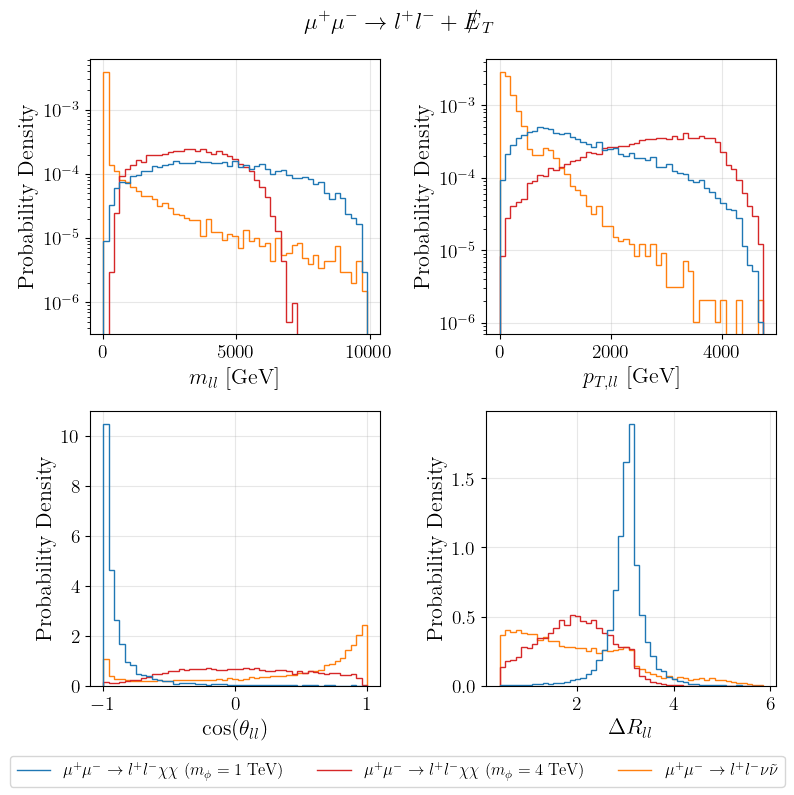

In [4]:
sig1_events = parse_lhe(DIR_llχχ * DIR_run01 * LHE_FILENAME)
sig2_events = parse_lhe(DIR_llχχ * DIR_run02 * LHE_FILENAME)
bkg_events = parse_lhe(DIR_llνν * DIR_run01 * LHE_FILENAME)

phi_masses = Vector{Int64}(1e-3 .* load_mg_masses(DIR_llχχ * SCAN_RESULTS_FILENAME))

labels = [L"$\mu^+ \mu^- \to l^+ l^- \chi \chi$ ($m_\phi = %$(phi_masses[1])$ TeV)",
        L"$\mu^+ \mu^- \to l^+ l^- \chi \chi$ ($m_\phi = %$(phi_masses[2])$ TeV)",
        L"\mu^+ \mu^- \to l^+ l^- \nu \tilde{\nu}"]

title = L"\mu^+ \mu^- \to l^+ l^- + \slashed{E}_T"

hist_fig = make_histograms(sig1_events, sig2_events, bkg_events, labels, title)
# hist_fig.savefig(FIGDIR * "mumu_to_llmet.pdf")
hist_fig

## Impact of Cuts

### $p_{T,ll}$

In [33]:
function percent_cut_pT(events, pT_mins)
    pTs = dilepton_pT.(events)

    return [sum(pTs .> pT_min)/length(events) for pT_min in pT_mins]
end

function make_ptcut_plot(ptcuts, lumi, signal_llχχ_path, signal_φφ_path, bkg_path)
    sig_xsecs = load_mg_xsec(signal_φφ_path * XSEC_RESULTS_FILENAME) # pb
    bkg_xsec = load_mg_xsec(bkg_path * XSEC_RESULTS_FILENAME)[1] # pb

    lhe_sig1 = parse_lhe(signal_llχχ_path * DIR_run01 * LHE_FILENAME)
    lhe_sig2 = parse_lhe(signal_llχχ_path * DIR_run02 * LHE_FILENAME)
    lhe_bkg = parse_lhe(bkg_path * DIR_run01 * LHE_FILENAME)

    background_err = sqrt.(bkg_xsec.*lumi.*percent_cut_pT(lhe_bkg, ptcuts))
    Nevent_sig1 = sig_xsecs[1].*lumi.*percent_cut_pT(lhe_sig1, ptcuts)
    Nevent_sig2 = sig_xsecs[2].*lumi.*percent_cut_pT(lhe_sig2, ptcuts)

    phi_masses = Vector{Int64}(1e-3 .* load_mg_masses(signal_llχχ_path * 
                SCAN_RESULTS_FILENAME))

    figg = figure()
    plot(ptcuts, Nevent_sig1 ./ background_err, color="tab:blue", 
        label=L"$m_\phi = %$(phi_masses[1])$ TeV")
    plot(ptcuts, Nevent_sig2 ./ background_err, color="tab:red", 
        label=L"$m_\phi = %$(phi_masses[2])$ TeV")

    xlabel(L"$p_{T,ll}$ min [GeV]")
    ylabel(L"N_S / \sqrt{N_B}")

    grid(alpha=0.3)

    legend()

    plotclose()
    return figg
end
;

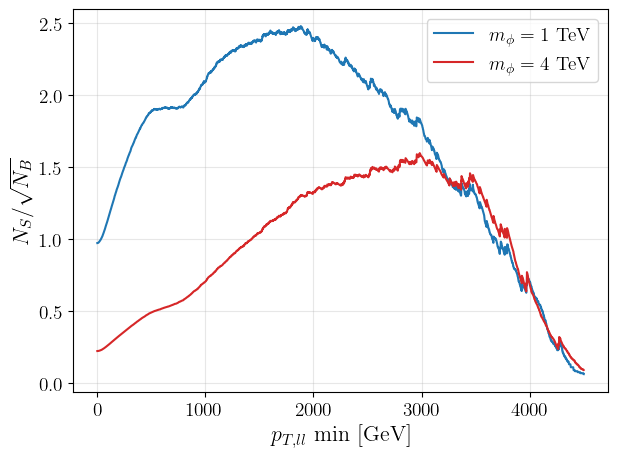

In [35]:
ptcut_fig = make_ptcut_plot(range(0,4500), 3*10^6, DIR_llχχ, DIR_φφ, DIR_llνν)
# ptcut_fig.savefig(FIGDIR * "ptcuts.pdf")
ptcut_fig

### all four

In [11]:
function fraction_cut(events, cuts)
    summary = reduce(hcat, dilepton_summarize.(events))

    mll_res = [sum(summary[1,:] .> mll_min)/length(events) for mll_min in cuts[1]]
    pt_res = [sum(summary[2,:] .> pt_min)/length(events) for pt_min in cuts[2]]
    cosθ_res = [sum(summary[3,:] .< cθ)/length(events) for cθ in cuts[3]]
    ΔR_res = [sum(summary[4,:] .> ΔR)/length(events) for ΔR in cuts[4]]
    
    return (mll_res, pt_res, cosθ_res, ΔR_res)
end

function make_cuts_plot(signal_llχχ_path, signal_φφ_path, bkg_path, cuts; 
        lumi=3e6, nbins=50)

    sig_xsecs = load_mg_xsec(signal_φφ_path * XSEC_RESULTS_FILENAME)[3:4] # pb
    bkg_xsec = load_mg_xsec(bkg_path * XSEC_RESULTS_FILENAME)[3] # pb

    lhe_sig1 = parse_lhe(signal_llχχ_path * "Events/run_03/" * LHE_FILENAME)
    lhe_sig2 = parse_lhe(signal_llχχ_path * "Events/run_04/" * LHE_FILENAME)
    lhe_bkg = parse_lhe(bkg_path * "Events/run_03/" * LHE_FILENAME)

    check_leptons(lhe_sig1)
    check_leptons(lhe_sig2)
    check_leptons(lhe_bkg)

    sig1_fracs = fraction_cut(lhe_sig1, cuts)
    sig2_fracs = fraction_cut(lhe_sig2, cuts)
    bkg_fracs = fraction_cut(lhe_bkg, cuts)

    background_err = [sqrt.(bkg_xsec.*lumi.*cutfrac) for cutfrac in bkg_fracs]
    Nevent_sig1 = [sig_xsecs[1].*lumi.*cutfrac for cutfrac in sig1_fracs]
    Nevent_sig2 = [sig_xsecs[2].*lumi.*cutfrac for cutfrac in sig2_fracs]

    phi_masses = Vector{Int64}(1e-3 .* load_mg_masses(signal_llχχ_path * 
                "Events/scan_run_0[3-4].txt"))

    xlabels = [L"$m_{ll}$ min [GeV]", L"$p_{T,ll}$ min [GeV]", 
                L"$\cos(\theta_{ll})$ max", L"$\Delta R_{ll}$ min"]

    fig, axs = subplots(2,2, figsize=(8, 8))

    iter = 1
    for ax in axs
        for a in ax
            a.plot(cuts[iter], Nevent_sig1[iter] ./ background_err[iter],
                color="tab:blue")
            a.plot(cuts[iter], Nevent_sig2[iter] ./ background_err[iter],
                color="tab:red")

            a.set_xlabel(xlabels[iter])
            a.set_ylabel(L"N_S / \sqrt{N_B}")

            a.grid(alpha=0.3)
            iter += 1
        end
    end

    axs[0,0].plot(0, Inf, lw=1., c="tab:blue",
        label=L"$m_\phi = %$(phi_masses[1])$ TeV")
    axs[0,0].plot(0, Inf, lw=1., c="tab:red",
        label=L"$m_\phi = %$(phi_masses[2])$ TeV")

    handles, labels = axs[0,0].get_legend_handles_labels()

    fig.legend(handles, labels, loc="lower center", ncol=2)

    fig.suptitle(L"Impact of cuts on $\mu^+ \mu^- \to l^+ l^- + \slashed{E}_T$")

    tight_layout(rect=(0, .04, 1, 1))

    plotclose()
    return fig
end
;

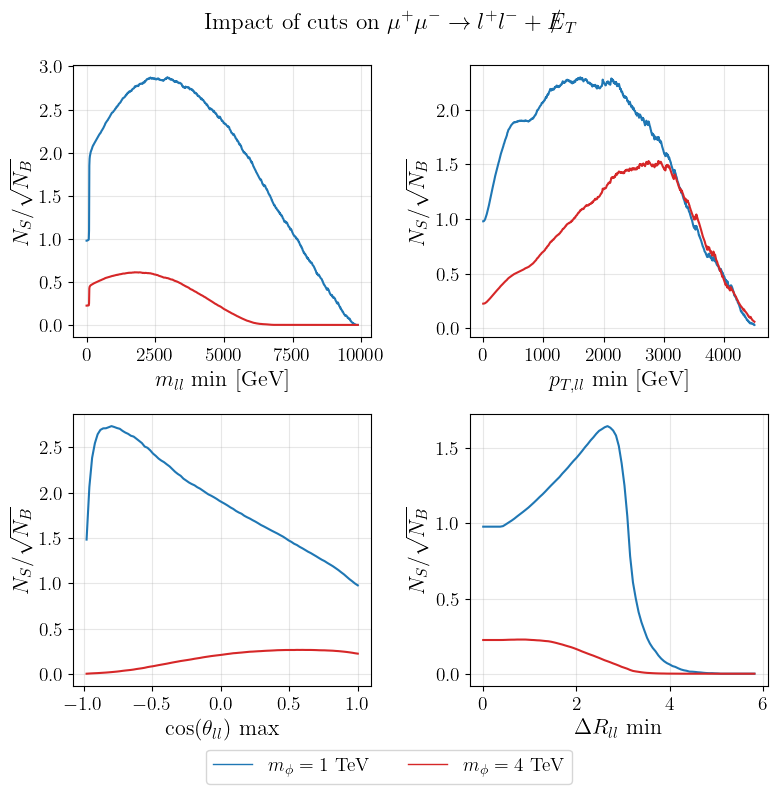

In [12]:
cuts = (range(0,10000,1000), range(0,4500,1000), range(-1,1,100), range(0,6,100))
cuts_fig = make_cuts_plot(DIR_llχχ, DIR_φφ, DIR_llνν, cuts)
# cuts_fig.savefig(FIGDIR * "cuts_impact.pdf")
cuts_fig

### per bin

In [57]:
function bin_data(x, bin_edges)
    result = zeros(Int64, length(bin_edges)-1)
    for i in 1:(length(bin_edges)-1)
        result[i] = sum(bin_edges[i] .< x .< bin_edges[i+1])
    end
    return result
end

function fraction_per_bin(lhes; nbins=50)
    summs = dilepton_summarize.(lhes)
    Ndata = length(summs[1][1,:])

    results = zeros(Float64, (length(lhes), 4, nbins))
    binn_edges = zeros(Float64, (4, nbins+1))

    for iter in 1:4
        binmin = min([minimum(s[iter,:]) for s in summs]...)
        binmax = max([maximum(s[iter,:]) for s in summs]...)
        binn_edges[iter,:] = range(binmin, binmax, nbins+1)

        for j in 1:length(lhes)
            results[j,iter,:] = bin_data(summs[j][iter,:], binn_edges[iter,:]) ./ Ndata
        end
    end
    
    return (results, binn_edges)
end

function make_binned_cuts_plot(signal_llχχ_path, signal_φφ_path, bkg_path; 
        lumi=3*10^6, nbins=50)

    sig_xsecs = load_mg_xsec(signal_φφ_path * XSEC_RESULTS_FILENAME) # pb
    bkg_xsec = load_mg_xsec(bkg_path * XSEC_RESULTS_FILENAME)[1] # pb
    xsecs = vcat(sig_xsecs, bkg_xsec)

    lhe_sig1 = parse_lhe(signal_llχχ_path * DIR_run01 * LHE_FILENAME)
    lhe_sig2 = parse_lhe(signal_llχχ_path * DIR_run02 * LHE_FILENAME)
    lhe_bkg = parse_lhe(bkg_path * DIR_run01 * LHE_FILENAME)

    check_leptons(lhe_sig1)
    check_leptons(lhe_sig2)
    check_leptons(lhe_bkg)

    fpb, bin_edges = fraction_per_bin([lhe_sig1, lhe_sig2, lhe_bkg], nbins=nbins)

    counts = [fpb[i,:,:].*xsecs[i].*lumi for i in 1:3]
    
    stddevs = [counts[i] ./ sqrt.(counts[3]) for i in 1:2]

    phi_masses = Vector{Int64}(1e-3 .* load_mg_masses(signal_llχχ_path * 
                SCAN_RESULTS_FILENAME))

    xlabels = [L"$m_{ll}$ [GeV]", L"$p_{T,ll}$ [GeV]", 
                L"$\cos(\theta_{ll})$", L"$\Delta R_{ll}$"]
    
    fig, axs = subplots(2,2, figsize=(8, 8))

    iter = 1
    for ax in axs
        for a in ax
            a.stairs(stddevs[1][iter,:], edges=bin_edges[iter,:], 
                color="tab:blue")
            a.stairs(stddevs[2][iter,:], edges=bin_edges[iter,:], 
                color="tab:red")
            
            # a.set_yscale("log")

            a.set_xlabel(xlabels[iter])
            a.set_ylabel(L"$N_S / \sqrt{N_B}$ per bin")

            a.grid(alpha=0.3)
            iter += 1
        end
    end

    axs[0,0].plot(0, Inf, lw=1., c="tab:blue",
        label=L"$m_\phi = %$(phi_masses[1])$ TeV")
    axs[0,0].plot(0, Inf, lw=1., c="tab:red",
        label=L"$m_\phi = %$(phi_masses[2])$ TeV")

    handles, labels = axs[0,0].get_legend_handles_labels()

    fig.legend(handles, labels, loc="lower center", ncol=2)

    fig.suptitle(L"Cuts per bin $\mu^+ \mu^- \to l^+ l^- + \slashed{E}_T$")

    tight_layout(rect=(0, .04, 1, 1))

    plotclose()
    return fig

end
;

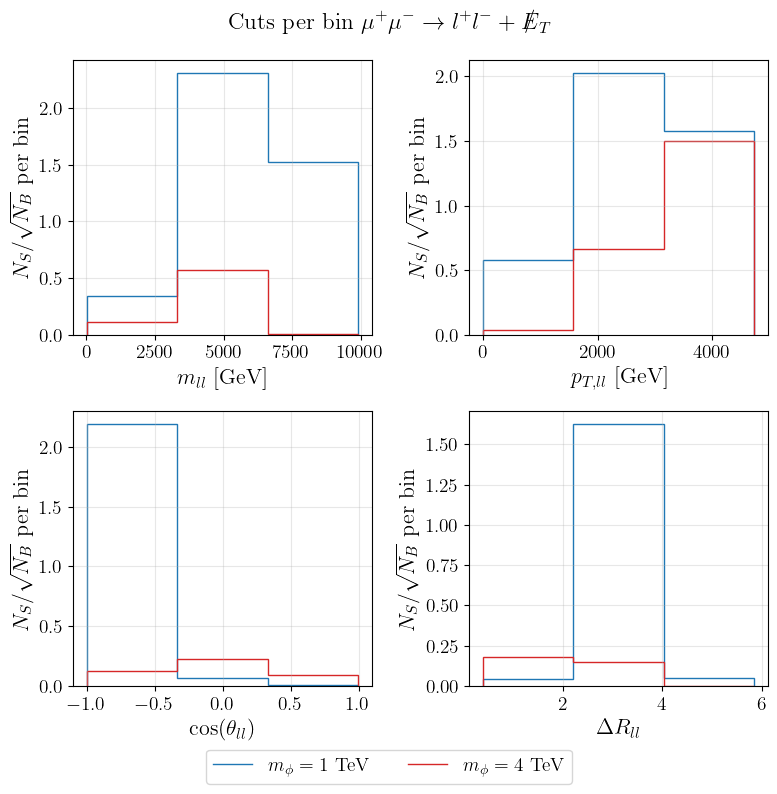

In [59]:
bincutfig = make_binned_cuts_plot(DIR_llχχ, DIR_φφ, DIR_llνν, nbins=3)
# bincutfig.savefig(FIGDIR * "cuts_per_bin.pdf")
bincutfig

### $p_{T,ll} \times m_{ll}$

In [13]:
function fraction_cut_pT_mll(events, pT_mins, mll_mins)
    summary = dilepton_summarize(events)
    Nevent = length(events)

    return reduce(hcat, [[sum((summary[1,:] .> mll_min) .&& 
            (summary[2,:] .> pt_min))/Nevent for mll_min in mll_mins] for 
            pt_min in pT_mins])
end

function make_ptmll_cut_plot(ptcuts, mllcuts, signal_llχχ_path, signal_φφ_path, 
        bkg_path; lumi=(3*10^6))

    sig_xsecs = load_mg_xsec(signal_φφ_path * XSEC_RESULTS_FILENAME)[3:4] # pb
    bkg_xsec = load_mg_xsec(bkg_path * XSEC_RESULTS_FILENAME)[3] # pb

    lhe_sig1 = parse_lhe(signal_llχχ_path * "Events/run_03/" * LHE_FILENAME)
    lhe_sig2 = parse_lhe(signal_llχχ_path * "Events/run_04/" * LHE_FILENAME)
    lhe_bkg = parse_lhe(bkg_path * "Events/run_03/" * LHE_FILENAME)

    background_err = sqrt.(bkg_xsec.*lumi.*fraction_cut_pT_mll(lhe_bkg, ptcuts,
                        mllcuts))
    Nevent_sig1 = sig_xsecs[1].*lumi.*fraction_cut_pT_mll(lhe_sig1, ptcuts,
                        mllcuts)
    Nevent_sig2 = sig_xsecs[2].*lumi.*fraction_cut_pT_mll(lhe_sig2, ptcuts,
                        mllcuts)

    phi_masses = Vector{Int64}(1e-3 .* load_mg_masses(signal_llχχ_path * 
                "Events/scan_run_0[3-4].txt"))

    fig, axs = subplots(1, 2, figsize=(8,4))

    q1 = axs[0].contourf(ptcuts, mllcuts, Nevent_sig1 ./ background_err)
    q2 = axs[1].contourf(ptcuts, mllcuts, Nevent_sig2 ./ background_err)

    for i in 0:1
        axs[i].set_ylabel(L"$m_{ll}$ min [GeV]")
        axs[i].set_xlabel(L"$p_{T,ll}$ min [GeV]")

        axs[i].grid(alpha=0.3)

        axs[i].set_title(L"$m_\phi = %$(phi_masses[i+1])$ TeV")

    end

    fig.colorbar(q1)
    fig.colorbar(q2)

    plotclose()
    return fig
end
;

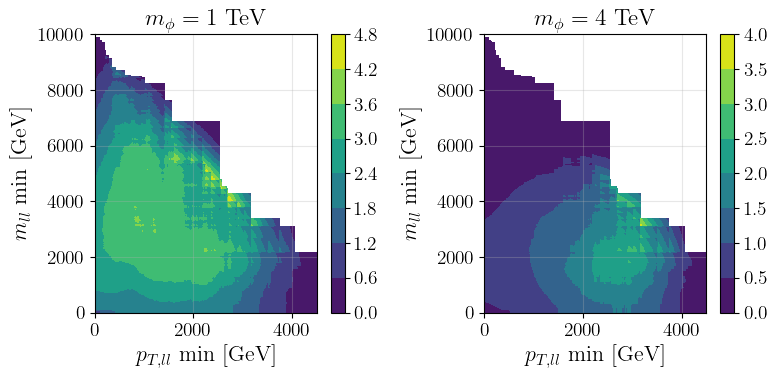

In [14]:
mll_cuts = range(0,10000,1000)
pT_cuts = range(0,4500,500)
ptmll_fig = make_ptmll_cut_plot(pT_cuts, mll_cuts, DIR_llχχ, DIR_φφ, DIR_llνν)
# ptmll_fig.savefig(FIGDIR * "pt_and_mll.pdf")
ptmll_fig

In [13]:
function fraction_cut_cross(events, idxs, mins)
    summary = dilepton_summarize(events)
    Nevent = length(events)

    coefs = ones(Float64, 2)

    for i in 1:2
        if idxs[i] == 3
            coefs[i] = -1
        end
    end

    return reduce(hcat, [[sum((coefs[2]*summary[idxs[2],:] .> coefs[2]*min1) .&& 
            (coefs[1]*summary[idxs[1],:] .> coefs[1]*min2))/Nevent 
            for min1 in mins[2]] for min2 in mins[1]])
end

function make_cross_cut_plot(cut_idxs, cuts, signal_llχχ_path, signal_φφ_path, 
        bkg_path; lumi=(3*10^6))

    sig_xsecs = load_mg_xsec(signal_φφ_path * XSEC_RESULTS_FILENAME) # pb
    bkg_xsec = load_mg_xsec(bkg_path * XSEC_RESULTS_FILENAME)[1] # pb

    lhe_sig1 = parse_lhe(signal_llχχ_path * DIR_run01 * LHE_FILENAME)
    lhe_sig2 = parse_lhe(signal_llχχ_path * DIR_run02 * LHE_FILENAME)
    lhe_bkg = parse_lhe(bkg_path * DIR_run01 * LHE_FILENAME)

    background_err = sqrt.(bkg_xsec.*lumi.*fraction_cut_cross(lhe_bkg, cut_idxs,
                        cuts))
    Nevent_sig1 = sig_xsecs[1].*lumi.*fraction_cut_cross(lhe_sig1, cut_idxs,
                        cuts)
    Nevent_sig2 = sig_xsecs[2].*lumi.*fraction_cut_cross(lhe_sig2, cut_idxs,
                        cuts)

    phi_masses = Vector{Int64}(1e-3 .* load_mg_masses(signal_llχχ_path * 
                SCAN_RESULTS_FILENAME))

    labels = [L"$m_{ll}$ min [GeV]", L"$p_{T,ll}$ min [GeV]",   
            L"$\cos(\theta_{ll})$ max", L"$\Delta R_{ll}$ min"]
    
    fig, axs = subplots(1, 2, figsize=(8,4))

    q1 = axs[0].contourf(cuts[1], cuts[2], Nevent_sig1 ./ background_err)
    q2 = axs[1].contourf(cuts[1], cuts[2], Nevent_sig2 ./ background_err)

    for i in 0:1
        axs[i].set_ylabel(labels[cut_idxs[2]])
        axs[i].set_xlabel(labels[cut_idxs[1]])

        axs[i].grid(alpha=0.3)

        axs[i].set_title(L"$m_\phi = %$(phi_masses[i+1])$ TeV")

    end

    fig.colorbar(q1)
    fig.colorbar(q2)

    plotclose()
    return fig
end
;

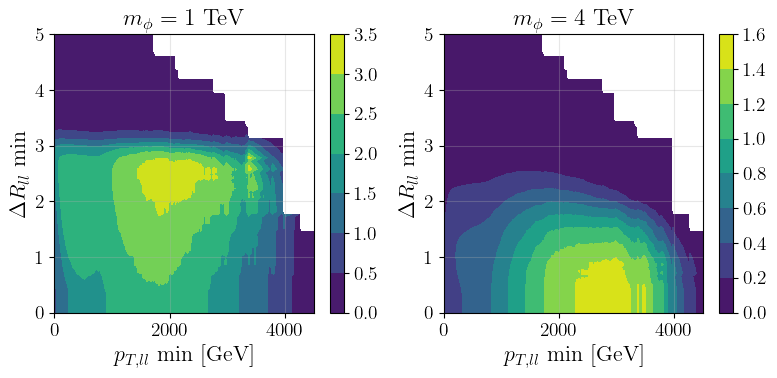

In [15]:
cuts = [range(0,4500,200), range(0,5,100)]
ptdR_fig = make_cross_cut_plot([2, 4], cuts, DIR_llχχ, DIR_φφ, DIR_llνν)
ptdR_fig.savefig(FIGDIR * "pt_and_dR.pdf")
ptdR_fig

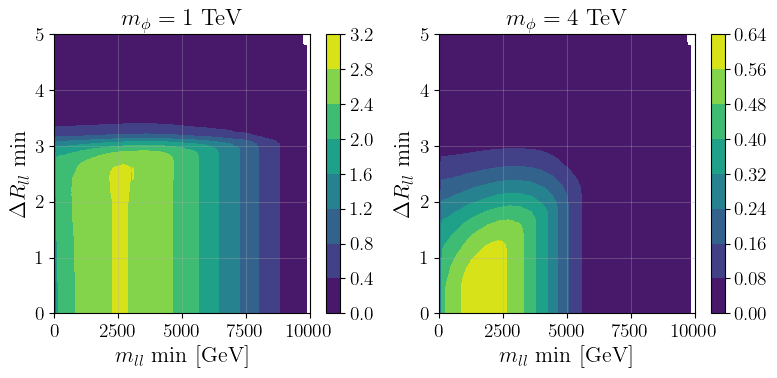

In [18]:
cuts = [range(0,10000,200), range(0,5,100)]
mlldR_fig = make_cross_cut_plot([1, 4], cuts, DIR_llχχ, DIR_φφ, DIR_llνν)
mlldR_fig.savefig(FIGDIR * "mll_and_dR.pdf")
mlldR_fig

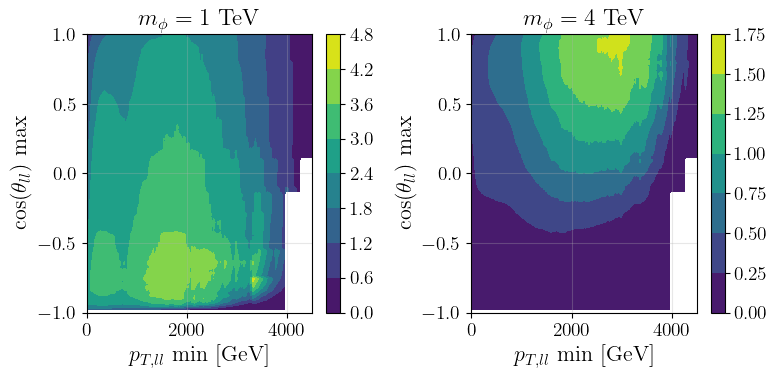

In [19]:
cuts = [range(0,4500,200), range(-1,1,100)]
ptθ_fig = make_cross_cut_plot([2, 3], cuts, DIR_llχχ, DIR_φφ, DIR_llνν)
ptθ_fig.savefig(FIGDIR * "pt_and_theta.pdf")
ptθ_fig

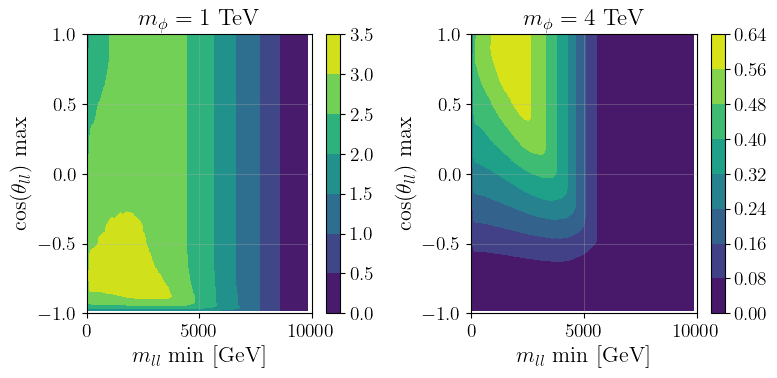

In [20]:
cuts = [range(0,10000,200), range(-1,1,100)]
mllθ_fig = make_cross_cut_plot([1, 3], cuts, DIR_llχχ, DIR_φφ, DIR_llνν)
# ptθ_fig.savefig(FIGDIR * "mll_and_theta.pdf")
mllθ_fig